In [1]:
from string import punctuation

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences

# Models
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback
from keras.layers import Input, Embedding, Dropout, LSTM, Dense, Activation, Reshape, Concatenate, RepeatVector
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
PATH_TO_DATA = '../data/'

TEXT_FILES_DIR = PATH_TO_DATA + 'Flickr8k_text/'
IMAGES_DIR = PATH_TO_DATA + 'Flickr8k_Dataset/Flicker8k_Dataset/'

***

## Understanding and formating the data

In [4]:
with open(TEXT_FILES_DIR + 'Flickr8k.token.txt', 'r') as flickr8_token:
    raw_image_description = flickr8_token.read().split('\n')[:-1]

print('\n'.join(raw_image_description[:10]))

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [5]:
def get_dict_image_descriptions(raw_image_description):
    image_descriptions = dict()
    
    i = 0
    while i < len(raw_image_description):
        img_name = raw_image_description[i].split('.')[0]
        image_descriptions[img_name] = []
        
        while i < len(raw_image_description) and img_name == raw_image_description[i].split('.')[0]:
            descr = raw_image_description[i].split('\t')[1]
            image_descriptions[img_name].append(descr)
            i+=1
            
    return image_descriptions

image_descriptions = get_dict_image_descriptions(raw_image_description)

In [6]:
image_descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [7]:
def clean(sentence):
    # Tokenize
    tokens = sentence.split()
    
    # Lower Case
    tokens = [token.lower() for token in tokens]
    
    # Remove punct
    for i in range(len(tokens)):
        tokens[i] = ''.join([ch for ch in tokens[i] if ch not in punctuation])
    
    # Remove hanging chars
    tokens = [token for token in tokens if len(token) > 1 or token == 'a']
    
    # Remove tokens with digits in it
    tokens = [token for token in tokens if token.isalpha()]
    
    return ' '.join(tokens)

In [8]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [9]:
for img_name, descriptions in image_descriptions.items():
    image_descriptions[img_name] = [clean(descr) for descr in descriptions]

In [10]:
image_descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [11]:
vocabulary = set()

for key in image_descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image_descriptions[key]]

In [12]:
vocabulary.update('0')
vocabulary.update(['<SOS>'])
vocabulary.update(['<EOS>'])

In [13]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [14]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [15]:
word2idx = {val: key for key, val in enumerate(vocabulary)}
idx2word = {key: val for key, val in enumerate(vocabulary)}

In [16]:
word2idx['dog']

2224

In [17]:
idx2word[2224]

'dog'

***

## Max Description Length

In [18]:
descriptions = []

for key, val in image_descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [19]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [20]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [21]:
def load_set_images(filename):
    with open(filename, 'r') as f:
        img_names = f.read().split('\n')[:-1]
        
    img_names = [name.split('.')[0] for name in img_names]
    return img_names

In [22]:
train_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.trainImages.txt')
dev_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.devImages.txt')
test_images = load_set_images(TEXT_FILES_DIR + 'Flickr_8k.testImages.txt')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [23]:
def init_image_descriptions_set(set_images):
    image_descriptions_set = dict()
    
    for img_name in set_images:
        image_descriptions_set[img_name] = []
        descriptions = image_descriptions[img_name]
        
        for descr in descriptions:
            image_descriptions_set[img_name].append(
                descr,
            )
    
    return image_descriptions_set

In [24]:
train_image_descriptions = init_image_descriptions_set(train_images)
dev_image_descriptions = init_image_descriptions_set(dev_images)
test_image_descriptions = init_image_descriptions_set(test_images)

print('Train size: {}'.format(len(train_image_descriptions)))
print('Dev size: {}'.format(len(dev_image_descriptions)))
print('Test size: {}'.format(len(test_image_descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [25]:
train_image_descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Data Generator

In [26]:
def load_image(x, target_size=(299, 299), preprocess=True):
    x = image.load_img(IMAGES_DIR+x+'.jpg', target_size=target_size)
    x = image.img_to_array(x)
    
    if preprocess:
        x = preprocess_input(x)

    return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


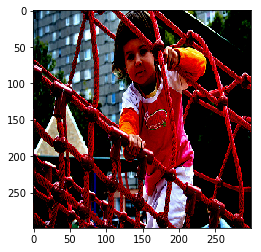

In [27]:
img = load_image('1007320043_627395c3d8')
# print(f'Image shape: {img.shape}')

plt.imshow(img);

In [28]:
# data generator, intended to be used in a call to model.fit_generator()

def data_generator(image_descriptions_set, word2idx, max_length, num_imgs_per_batch):
    X_img = []
    X_seq = []
    Y_seq = []
    n = 0
    
    # loop for ever over images
    while True:
        for img_id, desc_list in image_descriptions_set.items():
            # retrieve the photo feature
            img = load_image(img_id)

            for desc in desc_list:
                X_img.append(img)
                
                # encode the sequence
                y_seq = [word2idx[word] for word in desc.split()] + [word2idx['<EOS>']]
                x_seq = [word2idx['<SOS>']] + y_seq[:-1]
                
                Y_seq.append(y_seq)
                X_seq.append(x_seq)
            
            n+=1
            # yield the batch data
            if n == num_imgs_per_batch:
                X_seq = pad_sequences(X_seq, maxlen=max_length, padding='post')
                Y_seq = pad_sequences(Y_seq, maxlen=max_length, padding='post')
                
                # One-hot
                Y_seq = [[to_categorical(idx, len(vocabulary)) for idx in sent] for sent in Y_seq]
                
                yield [[np.array(X_img), X_seq], np.array(Y_seq)]

                X_img = []
                X_seq = []
                Y_seq = []
                n = 0

***

# Image Encoder (ConvNet)

We are making use of the **Transfer Learning** technique.<br>
We are using the CNN Inception V3 trained on ImageNet by Google Brain team on Cloud TPUs.
<br><br>

Here is the network architecture:
![InceptionV3](../img/InceptionV3.png)

In [29]:
IMG_EMBEDDING_DIM = 300

In [30]:
img_in = Input((299, 299, 3), name='image_input')
    
# Get the InceptionV3 model trained on imagenet data
inceptionv3 = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
inceptionv3 = Model(inceptionv3.input, inceptionv3.layers[-2].output, name='inceptionv3')

# Do not alter the weights of the InceptionV3 model
for layer in inceptionv3.layers:
    layer.trainable = False
    
x = inceptionv3(img_in)
x = Dropout(0.5, name='dropout_encoder')(x)
x = Dense(IMG_EMBEDDING_DIM, name='dense_encoder')(x)
x = Activation('relu', name='relu_encoder')(x)
    
image_encoder = Model(img_in, x, name='image_encoder')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
# plot_model(image_encoder, to_file='image_encoder.png', show_shapes=True, show_layer_names=True)

print(image_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 299, 299, 3)       0         
_________________________________________________________________
inceptionv3 (Model)          (None, 2048)              21802784  
_________________________________________________________________
dropout_encoder (Dropout)    (None, 2048)              0         
_________________________________________________________________
dense_encoder (Dense)        (None, 300)               614700    
_________________________________________________________________
relu_encoder (Activation)    (None, 300)               0         
Total params: 22,417,484
Trainable params: 614,700
Non-trainable params: 21,802,784
_________________________________________________________________
None


***

# Sequence Decoder (LSTM)
<br>
A LSTM network

![LSTM_net](../img/LSTM.png)

### Word Embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/))

In [32]:
GLOVE_300_DIR = PATH_TO_DATA + 'glove.6B/glove.6B.300d.txt'

def load_word_embedding_map(path_to_embeddings):
    word_embedding = dict()

    with open(GLOVE_300_DIR, encoding='utf-8') as f_embeddings:
        for line in f_embeddings:
            values = line.split()
            word_embedding[values[0]] = np.asarray(values[1:], dtype='float64')
    
    return word_embedding


# Load the Word Embeddings
word_embedding = load_word_embedding_map(GLOVE_300_DIR)

In [33]:
def cosine_similarity(v, w):
    return np.dot(v, w) / (np.linalg.norm(v) * np.linalg.norm(w))

In [34]:
cosine_similarity(
    word_embedding['man'] - word_embedding['woman'],
    word_embedding['king'] - word_embedding['queen']
)

0.40070248182725027

#### Init the embedding matrix

In [35]:
def init_embedding_matrix(dim):
    embedding_matrix = np.zeros((len(vocabulary), dim))

    for word, idx in word2idx.items():
        try:
            embedding_matrix[idx, :] = word_embedding[word]
        except KeyError:
            pass
        
    return embedding_matrix

embedding_matrix = init_embedding_matrix(300)
print('Embedding Matrix shape: {}'.format(embedding_matrix.shape))

Embedding Matrix shape: (8767, 300)


## Build the Sequence Decoder

In [38]:
# Sequence Input
seq_in = Input((max_description_length,), name='sequence_input')
image_embedding = Input((IMG_EMBEDDING_DIM,), name='image_embedding')


# GloVe embeddings
glove_embeddings = Embedding(
    len(vocabulary),
    300,
    input_length=max_description_length,
    mask_zero=True,
    name='glove_embeddings'
)
word_embeddings = glove_embeddings(seq_in)

# Dropout
embeddings_dropout = Dropout(0.5, name='embeddings_dropout')
word_embeddings = embeddings_dropout(word_embeddings)

# Image Embeddings
repeat_img_emb = RepeatVector(37, name='repeat_img_emb')
image_embeddings = repeat_img_emb(image_embedding)

# Concatenate the embeddings
concat_img_word_emb = Concatenate(name='concat_img_word_emb')
x = concat_img_word_emb([image_embeddings, word_embeddings])

# Sequence Decoder
lstm_decoder = LSTM(512, return_sequences=True, return_state=True, name='lstm_decoder')
x, _, _ = lstm_decoder(x)

# Dense -> Softmax
dense_decoder = Dense(len(vocabulary), name='dense_decoder')
x = dense_decoder(x)
softmax_decoder = Activation('softmax', name='softmax_decoder')
x = softmax_decoder(x)
    
sequence_decoder = Model(inputs=[seq_in, image_embedding], outputs=x, name='sequence_decoder')
# Set GloVe weights
sequence_decoder.get_layer('glove_embeddings').set_weights([embedding_matrix])
sequence_decoder.get_layer('glove_embeddings').trainable = False


In [39]:
# plot_model(sequence_decoder, to_file='sequence_decoder.png', show_shapes=True, show_layer_names=True)

print(sequence_decoder.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
image_embedding (InputLayer)    (None, 300)          0                                            
__________________________________________________________________________________________________
glove_embeddings (Embedding)    (None, 37, 300)      2630100     sequence_input[0][0]             
__________________________________________________________________________________________________
repeat_img_emb (RepeatVector)   (None, 37, 300)      0           image_embedding[0][0]            
__________________________________________________________________________________________________
embeddings

***

# Model

![NIC_model](../img/NIC.png)

In [40]:
img_embedding = image_encoder(img_in)
seq_out = sequence_decoder([seq_in, img_embedding])

# Build the model
model = Model(inputs=[img_in, seq_in], outputs=seq_out, name='NIC')


### Visualize the model

In [41]:
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
image_encoder (Model)           (None, 300)          22417484    image_input[0][0]                
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     9406995     sequence_input[0][0]             
                                                                 image_encoder[1][0]              
Total para

***

# Inference

![LSTM_sampling](../img/Sampling.png)

In [42]:
img_id = '1015118661_980735411b'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


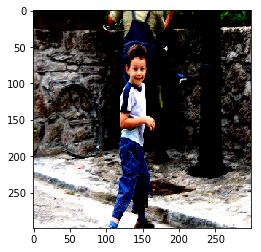

In [43]:
img = load_image(img_id)
plt.imshow(img);

In [44]:
image_descriptions[img_id]

['a boy smiles in front of a stony wall in a city',
 'a little boy is standing on the street while a man in overalls is working on a stone wall',
 'a young boy runs aross the street',
 'a young child is walking on a stone paved street with a metal pole and a man behind him',
 'smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him']

In [53]:
def init_inference_decoder():
    word_embeddings = glove_embeddings(seq_in)
    word_embeddings = embeddings_dropout(word_embeddings)

    image_embeddings = repeat_img_emb(image_embedding)

    x = concat_img_word_emb([image_embeddings, word_embeddings])

    output_tokens, h_state, c_state = lstm_decoder(x)
    output_tokens = dense_decoder(output_tokens)
    output_tokens = softmax_decoder(output_tokens)

    inference_decoder = Model([seq_in, im], [output_tokens, h_state, c_state])
    
    return inference_decoder

inference_decoder = init_inference_decoder()


def inference(image):
    encoder_vector = image_encoder.predict(np.array([image]))[0]
    states_values = [np.array([encoder_vector]), np.array([encoder_vector])]

    target_seq = np.zeros((1, max_description_length))
    target_seq[0, 0] = word2idx['<SOS>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h_state, c_state = inference_decoder.predict([target_seq]+states_values)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = idx2word[sampled_token_index]
        decoded_sentence += sampled_word + ' '

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_word == '<EOS>' or
           len(decoded_sentence.split()) > max_description_length):
            stop_condition = True
        
        target_seq = np.zeros((1, max_description_length))
        target_seq[0, 0] = sampled_token_index
        
        states_values = [h_state, c_state]

    return decoded_sentence[:-1]

In [54]:
# 'subdivsion magnificant affectionately '

inference(img)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 3 arrays: [array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]]), array([[0.7988963 , 0.  ...

***

## Run

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


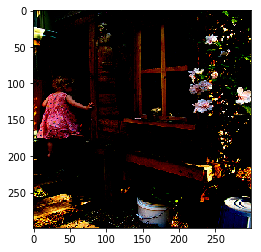

In [52]:
plt.imshow(load_image('1000268201_693b08cb0e'));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


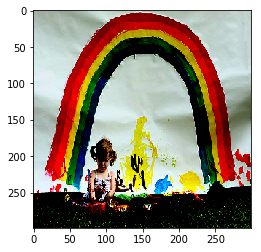

In [53]:
plt.imshow(load_image('1002674143_1b742ab4b8'));

### Callbacks

In [54]:
filepath = 'weights/weights-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

def on_epoch_end(epoch, log):
    if epoch % 5 == 0:
        img1 = load_image('1000268201_693b08cb0e')
        img2 = load_image('1002674143_1b742ab4b8')

        print(inference(img1))
        print(inference(img2))

lambda_callback = LambdaCallback(on_epoch_end=on_epoch_end)


callbacks = [checkpoint, lambda_callback]

In [60]:
model.load_weights('./weights/weights-106.hdf5')
model.compile(Adam(0.0001), loss='categorical_crossentropy')

In [61]:
num_imgs_per_batch = 3
steps = len(train_image_descriptions) // num_imgs_per_batch

model.fit_generator(
    data_generator(train_image_descriptions, word2idx, max_description_length, num_imgs_per_batch),
    steps_per_epoch=steps,
    epochs=1000,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/1000
2000/2000 [==============================] - 237s 119ms/step - loss: 2.7288

Epoch 00001: saving model to weights/weights-01.hdf5


/usr/local/lib/python3.5/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'h_state_input:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'c_state_input:0' shape=(?, 256) dtype=float32>], 'mask': [<tf.Tensor 'sequence_decoder/glove_embeddings/NotEqual:0' shape=(?, 37) dtype=bool>, None, None]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


a man in a blue shirt is standing in front of a large building <EOS>
a girl in a pink shirt is running on a beach <EOS>
Epoch 2/1000
2000/2000 [==============================] - 233s 117ms/step - loss: 2.6894

Epoch 00002: saving model to weights/weights-02.hdf5
Epoch 3/1000
2000/2000 [==============================] - 234s 117ms/step - loss: 2.6727

Epoch 00003: saving model to weights/weights-03.hdf5
Epoch 4/1000
  90/2000 [>.............................] - ETA: 3:39 - loss: 2.5896

KeyboardInterrupt: 